In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch import optim
import numpy as np
import pandas as pd
import os, time, random
import matplotlib.pyplot as plt
from utils import one_hot, resize_to_ori_calMRE, resize_to_ori
import math


C:\Users\WIN10\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define save path

In [2]:
folder = 'election_GAN(pytorch)/'
gen_results = 'generated_results/'

model = 'model_'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# save generated data
generated_path = os.path.join(folder + gen_results)

# Load data

In [3]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3.iloc[:1000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4.iloc[:1000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
print(data_alt_3_4.shape)

(1000, 24, 30)
(1000, 24, 30)
(2000, 24, 30)


In [4]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [5]:
label_alt3 = np.zeros([data_alt3.shape[0]])
label_alt4 = np.zeros([data_alt4.shape[0]]) + 1
label_alt_3_4 = np.concatenate( (label_alt3,label_alt4), axis = 0)

label_alt_onehot = one_hot(label_alt_3_4, 1 + 1)   
print(label_alt_onehot.shape)

(2000, 2)


# Define Generator and discriminator

In [6]:
def gradient_penalty(dis, x_real, x_fake, x_label, device="cpu"):
    batch_size, height, width = x_real.shape
    alpha = torch.rand((batch_size, 1, 1)).repeat(1, height, width).to(device)
    interpolated_images = x_real * alpha + x_fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images, x_label)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim = 128, num_classes = 2):
        super(Generator, self).__init__()
        self.dim = 128
        self.hidden = torch.nn.Linear(z_dim + num_classes, self.dim*1*1*3)   
        self.tconv1 = self.conv_block(self.dim*3, self.dim*3, k_size=[1,5], stride=[1,5], pad=0, out_pad=0, use_bn=False)
        self.tconv2 = self.conv_block(self.dim*3, self.dim*2, k_size=[4,1], stride=[4,1], pad=0, out_pad=0, use_bn=False)
        self.tconv3 = self.conv_block(self.dim*2, self.dim*1, k_size=[3,3], stride=[3,3], pad=0, out_pad=0, use_bn=False)
        self.tconv4 = self.conv_block(self.dim*1, 1, k_size=[2,2], stride=[2,2], pad=0, out_pad=0, use_bn=False)        
        
    def conv_block(self, c_in, c_out, k_size, stride, pad, out_pad, use_bn=False):
        module = []
        module.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, padding=pad, output_padding=out_pad, bias=not use_bn))
        if use_bn: module.append(nn.BatchNorm2d(c_out))
        return nn.Sequential(*module)        

    def forward(self, x, label):
        x = x.reshape([x.shape[0], -1, 1, 1])
        label = label.reshape([x.shape[0], -1, 1, 1])
        x = torch.cat((x, label), dim=1).reshape([x.shape[0], -1])
        x = F.relu(self.hidden(x)).reshape([x.shape[0], 3*self.dim, 1, 1])
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = self.tconv3(x)
        x = self.tconv4(x)
        
        return x.squeeze()

In [8]:
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    
class Discriminator(nn.Module):
    def __init__(self, num_classes = 2):
        super(Discriminator, self).__init__()
        self.dim = 128
        self.height = 24
        self.width = 30
        self.conv1 = self.conv_block(1 + num_classes, self.dim, k_size=[4,5], stride=[2,2], pad=0)
        self.conv2 = self.conv_block(self.dim, self.dim * 2, k_size=[4,5], stride=[2,2], pad=0)
        self.conv3 = self.conv_block(self.dim * 2, self.dim * 2, k_size=[4,5], stride=[2,2], pad=0)
        self.hidden = torch.nn.Linear(3072, 1)  

    def conv_block(self, c_in, c_out, k_size, stride, pad=0, use_bn=False):
        module = []
        module.append(Conv2dSame(in_channels=c_in, 
                                 out_channels=c_out, kernel_size=k_size, stride=stride, groups=1, bias=not use_bn))
        if use_bn: module.append(nn.BatchNorm2d(c_out))
        return nn.Sequential(*module)        
        
    def forward(self, x, label):
        alpha = 0.2
        x = x.reshape([batch_size, 1, self.height, self.width])
        label = label.reshape([batch_size, 2, self.height, self.width])
        x = torch.cat((x, label), dim=1)
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = self.conv3(x)
        x = x.reshape([x.shape[0], -1])
        x = self.hidden(x)
                        
        return x.squeeze()

In [9]:
class election_GAN(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                lambda_gp = None):
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
#         self.device = "cpu" 
        self.num_samples = num_samples
        self.dim_height = dim_height
        self.dim_width = dim_width
        self.dim_z = dim_z
        self.num_class = num_class
        self.batch_size = batch_size
        self.lambda_gp = lambda_gp
       
    def train_model(self,
                    x_train = None,     
                    y_train = None,
                    dataloder_num_workers = 1,
                    train_epoch = 17000, 
                    step_valid = 50,
                    step_save_data = 1000,
                    iteration_generator = None,
                    n_critic = 5,
                   ):
        '''define gen, dis and optim'''
        self.gen = Generator(z_dim = self.dim_z, num_classes = self.num_class).to(self.device)
        self.dis = Discriminator(num_classes = self.num_class).to(self.device)

        self.g_opt = optim.Adam(self.gen.parameters(), lr=0.0001, betas=(0.5, 0.9))
        self.d_opt = optim.Adam(self.dis.parameters(), lr=0.0001, betas=(0.5, 0.9))
        
        '''load data into dataloder'''
        torch_dataset = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))

        data_loader = Data.DataLoader(dataset = torch_dataset, batch_size = self.batch_size, 
                                shuffle = True, num_workers = dataloder_num_workers, drop_last = True)
        
        
        ''' Training '''
        self.train_hist = {}
        self.train_hist['D_losses'] = []
        self.train_hist['G_losses'] = []

        time_start=time.time()

        print('Optimization start!')
        for epoch in range(train_epoch):
            G_losses = []
            D_losses = []

            time_start_epoch = time.time()

            for i, data in enumerate(data_loader):
                x_real, x_label = data        
                x_real = x_real.to(self.device)

                z_label = x_label.reshape([self.batch_size, self.num_class, 1, 1]).to(self.device)
                np_ones = np.ones([self.batch_size, self.num_class, self.dim_height, self.dim_width])
                x_label = z_label * torch.Tensor(np_ones).to(self.device)

                '''#############        Discriminator       #######################'''
                z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                x_fake = self.gen(z_fake, z_label)
#                 print(x_fake.shape)
#                 break
#             break
                
                
                fake_out = self.dis(x_fake.detach(), x_label)
                real_out = self.dis(x_real.detach(), x_label)
                gp = gradient_penalty(self.dis, x_real, x_fake, x_label, device = self.device)
                self.d_loss = (-(torch.mean(real_out) - torch.mean(fake_out)) + self.lambda_gp * gp)

                self.dis.zero_grad()
                self.d_loss.backward()
                self.d_opt.step()  
                D_losses.append(self.d_loss.data.cpu().numpy())

                '''#############        Generator          #######################'''
                if (i+1) % n_critic == 0:  
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    y_ = []
                    for _ in range(self.batch_size): y_.append(random.randrange(0, self.num_class, self.num_class-1))  
                    y_ = np.array(y_).reshape([self.batch_size, 1])
                    z_label = one_hot(y_, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    x_label = z_label * np.ones([self.batch_size, self.num_class, self.dim_height, self.dim_width])
                    z_label = torch.Tensor(z_label).to(self.device)    
                    x_label = torch.Tensor(x_label).to(self.device)    

                    x_fake = self.gen(z_fake, z_label)
                    fake_out = self.dis(x_fake, x_label)
                    self.g_loss = -torch.mean(fake_out)

                    self.g_opt.zero_grad()
                    self.g_loss.backward()
                    self.g_opt.step()
                    G_losses.append(self.g_loss.data.cpu().numpy())


            ############        show loss      #######################
            if (epoch+1) % 1 == 0:
                print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
                self.train_hist['D_losses'].append(np.mean(D_losses))
                self.train_hist['G_losses'].append(np.mean(G_losses))

            ############        visualize generated data      #######################
            if (epoch+1) % step_valid == 0:
                with torch.no_grad():
                   ############        num_alternative = 3      #######################
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    z_label = np.zeros([self.batch_size, 1]) + 0
                    z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    z_label = torch.Tensor(z_label).to(self.device)    

                    gen_alt3 = self.gen(z_fake, z_label)
                    ############        num_alternative = 4      #######################
                    z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                    z_label = np.zeros([self.batch_size, 1]) + 1
                    z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                    z_label = torch.Tensor(z_label).to(self.device)    

                    gen_alt4 = self.gen(z_fake, z_label)

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(3, 3))
                    ax.cla()
                    ax.imshow(gen_alt3.data.cpu().numpy()[0], cmap='gray')

                    fig, ax = plt.subplots(figsize=(3, 3))
                    ax.cla()
                    ax.imshow(gen_alt4.data.cpu().numpy()[0], cmap='gray')            
                    plt.show()      

            ############        save per 1000 epoch      #######################
            if (epoch+1) % step_save_data == 0:
                with torch.no_grad():

                    generated_3alt = []
                    generated_4alt = []                     
                    for _ in range(iteration_generator):  
                       ############        num_alternative = 3      #######################
                        z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                        z_label = np.zeros([self.batch_size, 1]) + 0
                        z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                        z_label = torch.Tensor(z_label).to(self.device)    
                        gen_alt3 = self.gen(z_fake, z_label)
                        generated_3alt.append(gen_alt3.data.cpu().numpy().reshape([self.batch_size, self.dim_height, self.dim_width]))

                        ############        num_alternative = 4      #######################
                        z_fake = torch.randn(self.batch_size, self.dim_z, 1, 1).to(self.device)
                        z_label = np.zeros([self.batch_size, 1]) + 1
                        z_label = one_hot(z_label, self.num_class).reshape([self.batch_size, self.num_class, 1, 1])
                        z_label = torch.Tensor(z_label).to(self.device)    
                        gen_alt4 = self.gen(z_fake, z_label)
                        generated_4alt.append(gen_alt4.data.cpu().numpy().reshape([self.batch_size, self.dim_height, self.dim_width]))

                    generated_3alt = np.array(generated_3alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])
                    gen_alt3_ori = resize_to_ori(generated_3alt, np.math.factorial(6), 30, 24, np.math.factorial(3), self.batch_size, iteration_generator)
                    gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
                    gen_alt3_pd.to_csv(generated_path + 'generated_atl3_' + str(epoch) + '.csv')                    

                    generated_4alt = np.array(generated_4alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])     
                    gen_alt4_ori = resize_to_ori(generated_4alt, np.math.factorial(6), 30, 24, np.math.factorial(4), self.batch_size, iteration_generator)
                    gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
                           'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
                           'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
                    gen_alt4_pd.to_csv(generated_path + 'generated_atl4_' + str(epoch) + '.csv')   

            time_end_epoch = time.time()
            print('Time cost in one epoch', time_end_epoch - time_start_epoch,'s')         

        ###########        save      #######################
        torch.save(self.gen, saver_path + 'gen.pkl')
        torch.save(self.dis, saver_path + 'dis.pkl')
        print('save success')    


        print("Optimization Finished!")

        time_end=time.time()
        print('Total Time cost',time_end-time_start,'s')
        
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['D_losses']))

        y1 = self.train_hist['D_losses']
        y2 = self.train_hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()

In [10]:
batch_size = 64

model = election_GAN(
                num_samples = data_alt_3_4.shape[0],
                dim_height = data_alt_3_4.shape[1],
                dim_width = data_alt_3_4.shape[2],
                dim_z = 128,
                num_class = label_alt_onehot.shape[-1],
                batch_size = batch_size,
                lambda_gp = 10)

Optimization start!
[1/2000] loss_d: -4.716, loss_g: 5.761
Time cost in one epoch 6.184567451477051 s
[2/2000] loss_d: -8.484, loss_g: 3.864
Time cost in one epoch 4.020575046539307 s
[3/2000] loss_d: -1.959, loss_g: -3.482
Time cost in one epoch 4.157049655914307 s
[4/2000] loss_d: -1.657, loss_g: 1.499
Time cost in one epoch 4.090405225753784 s
[5/2000] loss_d: -2.232, loss_g: -2.977
Time cost in one epoch 4.207930564880371 s
[6/2000] loss_d: -2.226, loss_g: -3.260
Time cost in one epoch 4.281142234802246 s
[7/2000] loss_d: -2.209, loss_g: -4.982
Time cost in one epoch 4.217865943908691 s
[8/2000] loss_d: -2.243, loss_g: -6.501
Time cost in one epoch 4.144240856170654 s
[9/2000] loss_d: -2.237, loss_g: -5.459
Time cost in one epoch 4.162174224853516 s
[10/2000] loss_d: -2.240, loss_g: -5.569
Time cost in one epoch 4.234629154205322 s
[11/2000] loss_d: -2.231, loss_g: -3.780
Time cost in one epoch 4.25999903678894 s
[12/2000] loss_d: -2.243, loss_g: -4.262
Time cost in one epoch 4.209

<Figure size 640x480 with 0 Axes>

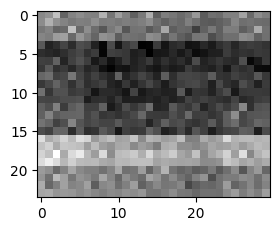

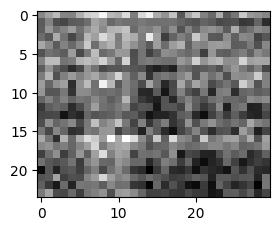

Time cost in one epoch 4.65325403213501 s
[26/2000] loss_d: -1.800, loss_g: 3.252
Time cost in one epoch 4.3238205909729 s
[27/2000] loss_d: -1.756, loss_g: 2.627
Time cost in one epoch 4.36810564994812 s
[28/2000] loss_d: -1.801, loss_g: 3.191
Time cost in one epoch 4.364427804946899 s
[29/2000] loss_d: -1.738, loss_g: 2.025
Time cost in one epoch 5.003641605377197 s
[30/2000] loss_d: -1.704, loss_g: 0.157
Time cost in one epoch 4.3999128341674805 s
[31/2000] loss_d: -1.654, loss_g: 0.730
Time cost in one epoch 4.371699810028076 s
[32/2000] loss_d: -1.605, loss_g: 0.368
Time cost in one epoch 4.3301520347595215 s
[33/2000] loss_d: -1.618, loss_g: 0.504
Time cost in one epoch 4.46607780456543 s
[34/2000] loss_d: -1.562, loss_g: 0.299
Time cost in one epoch 4.4108216762542725 s
[35/2000] loss_d: -1.580, loss_g: 1.417
Time cost in one epoch 4.483160734176636 s
[36/2000] loss_d: -1.587, loss_g: 1.755
Time cost in one epoch 5.059366464614868 s
[37/2000] loss_d: -1.562, loss_g: 3.394
Time c

<Figure size 640x480 with 0 Axes>

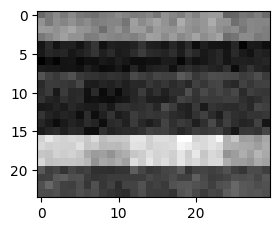

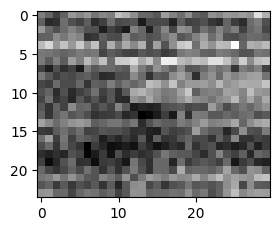

Time cost in one epoch 4.791692733764648 s
[51/2000] loss_d: -1.241, loss_g: 7.537
Time cost in one epoch 4.548080205917358 s
[52/2000] loss_d: -1.168, loss_g: 8.559
Time cost in one epoch 4.600311279296875 s
[53/2000] loss_d: -1.114, loss_g: 7.720
Time cost in one epoch 4.43528413772583 s
[54/2000] loss_d: -1.128, loss_g: 9.201
Time cost in one epoch 4.840405225753784 s
[55/2000] loss_d: -1.111, loss_g: 8.595
Time cost in one epoch 4.541079759597778 s
[56/2000] loss_d: -1.060, loss_g: 9.146
Time cost in one epoch 4.51631498336792 s
[57/2000] loss_d: -1.130, loss_g: 8.774
Time cost in one epoch 4.536667346954346 s
[58/2000] loss_d: -1.091, loss_g: 10.236
Time cost in one epoch 5.128105163574219 s
[59/2000] loss_d: -1.017, loss_g: 11.107
Time cost in one epoch 4.455018043518066 s
[60/2000] loss_d: -1.027, loss_g: 11.089
Time cost in one epoch 4.42401385307312 s
[61/2000] loss_d: -1.045, loss_g: 11.985
Time cost in one epoch 4.746657609939575 s
[62/2000] loss_d: -1.010, loss_g: 12.309
Ti

<Figure size 640x480 with 0 Axes>

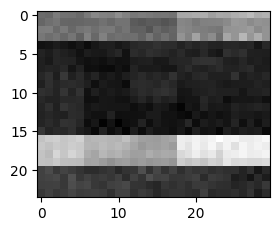

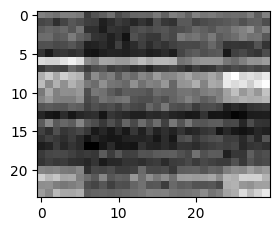

Time cost in one epoch 4.912707090377808 s
[76/2000] loss_d: -0.768, loss_g: 13.506
Time cost in one epoch 4.525192737579346 s
[77/2000] loss_d: -0.772, loss_g: 14.809
Time cost in one epoch 4.48235297203064 s
[78/2000] loss_d: -0.757, loss_g: 14.085
Time cost in one epoch 4.499424695968628 s
[79/2000] loss_d: -0.718, loss_g: 14.050
Time cost in one epoch 4.539425849914551 s
[80/2000] loss_d: -0.660, loss_g: 14.676
Time cost in one epoch 4.4983086585998535 s
[81/2000] loss_d: -0.662, loss_g: 15.672
Time cost in one epoch 4.4779558181762695 s
[82/2000] loss_d: -0.671, loss_g: 14.389
Time cost in one epoch 4.692969083786011 s
[83/2000] loss_d: -0.642, loss_g: 13.164
Time cost in one epoch 4.504785776138306 s
[84/2000] loss_d: -0.581, loss_g: 13.686
Time cost in one epoch 4.518786191940308 s
[85/2000] loss_d: -0.616, loss_g: 14.172
Time cost in one epoch 4.4682533740997314 s
[86/2000] loss_d: -0.624, loss_g: 13.328
Time cost in one epoch 4.471971035003662 s
[87/2000] loss_d: -0.563, loss_

<Figure size 640x480 with 0 Axes>

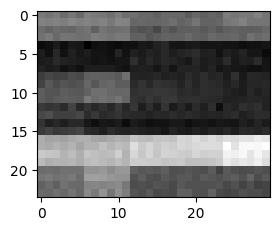

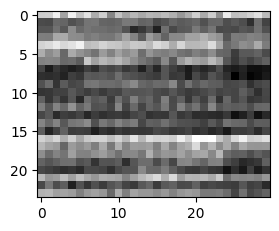

Time cost in one epoch 4.2847747802734375 s
[101/2000] loss_d: -0.511, loss_g: 13.000
Time cost in one epoch 4.14048433303833 s
[102/2000] loss_d: -0.578, loss_g: 10.677
Time cost in one epoch 4.24529242515564 s
[103/2000] loss_d: -0.504, loss_g: 10.629
Time cost in one epoch 4.242696046829224 s
[104/2000] loss_d: -0.439, loss_g: 11.247
Time cost in one epoch 4.1953349113464355 s
[105/2000] loss_d: -0.496, loss_g: 9.735
Time cost in one epoch 4.229424238204956 s
[106/2000] loss_d: -0.449, loss_g: 11.364
Time cost in one epoch 4.204338788986206 s
[107/2000] loss_d: -0.471, loss_g: 11.530
Time cost in one epoch 4.215071439743042 s
[108/2000] loss_d: -0.475, loss_g: 10.413
Time cost in one epoch 4.299761056900024 s
[109/2000] loss_d: -0.435, loss_g: 10.143
Time cost in one epoch 4.263819456100464 s
[110/2000] loss_d: -0.427, loss_g: 10.113
Time cost in one epoch 4.334280014038086 s
[111/2000] loss_d: -0.455, loss_g: 10.583
Time cost in one epoch 4.484516620635986 s
[112/2000] loss_d: -0.4

<Figure size 640x480 with 0 Axes>

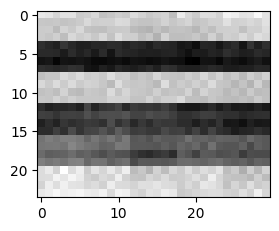

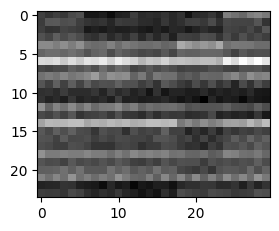

Time cost in one epoch 4.629894495010376 s
[126/2000] loss_d: -0.432, loss_g: 7.593
Time cost in one epoch 4.566226959228516 s
[127/2000] loss_d: -0.404, loss_g: 6.221
Time cost in one epoch 4.37778639793396 s
[128/2000] loss_d: -0.438, loss_g: 7.183
Time cost in one epoch 4.39601469039917 s
[129/2000] loss_d: -0.412, loss_g: 7.453
Time cost in one epoch 4.391293525695801 s
[130/2000] loss_d: -0.419, loss_g: 7.830
Time cost in one epoch 4.400841236114502 s
[131/2000] loss_d: -0.465, loss_g: 6.928
Time cost in one epoch 4.310945510864258 s
[132/2000] loss_d: -0.362, loss_g: 7.090
Time cost in one epoch 4.337177991867065 s
[133/2000] loss_d: -0.427, loss_g: 7.740
Time cost in one epoch 4.543024063110352 s
[134/2000] loss_d: -0.399, loss_g: 7.360
Time cost in one epoch 4.422602891921997 s
[135/2000] loss_d: -0.394, loss_g: 7.025
Time cost in one epoch 4.377195596694946 s
[136/2000] loss_d: -0.425, loss_g: 6.795
Time cost in one epoch 4.306187629699707 s
[137/2000] loss_d: -0.362, loss_g: 

<Figure size 640x480 with 0 Axes>

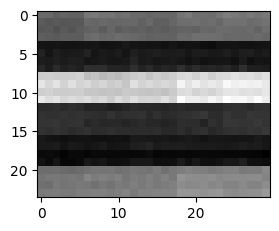

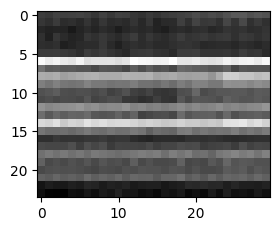

Time cost in one epoch 4.7219932079315186 s
[151/2000] loss_d: -0.372, loss_g: 5.162
Time cost in one epoch 4.758833169937134 s
[152/2000] loss_d: -0.420, loss_g: 4.821
Time cost in one epoch 4.39576268196106 s
[153/2000] loss_d: -0.366, loss_g: 4.358
Time cost in one epoch 4.3483452796936035 s
[154/2000] loss_d: -0.322, loss_g: 4.246
Time cost in one epoch 4.4540205001831055 s
[155/2000] loss_d: -0.300, loss_g: 5.021
Time cost in one epoch 4.37986421585083 s
[156/2000] loss_d: -0.352, loss_g: 3.390
Time cost in one epoch 4.380525827407837 s
[157/2000] loss_d: -0.355, loss_g: 4.843
Time cost in one epoch 4.444411277770996 s
[158/2000] loss_d: -0.351, loss_g: 5.125
Time cost in one epoch 4.4993577003479 s
[159/2000] loss_d: -0.341, loss_g: 5.476
Time cost in one epoch 4.393747806549072 s
[160/2000] loss_d: -0.315, loss_g: 5.715
Time cost in one epoch 4.3953423500061035 s
[161/2000] loss_d: -0.363, loss_g: 4.862
Time cost in one epoch 4.415761947631836 s
[162/2000] loss_d: -0.339, loss_g

<Figure size 640x480 with 0 Axes>

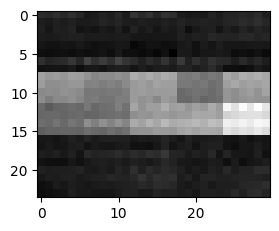

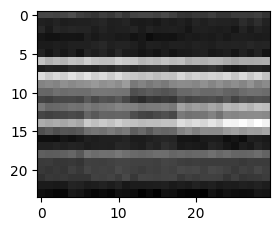

Time cost in one epoch 4.2666802406311035 s
[176/2000] loss_d: -0.260, loss_g: 3.689
Time cost in one epoch 4.181392669677734 s
[177/2000] loss_d: -0.360, loss_g: 4.694
Time cost in one epoch 4.1553473472595215 s
[178/2000] loss_d: -0.336, loss_g: 4.928
Time cost in one epoch 4.086597919464111 s
[179/2000] loss_d: -0.311, loss_g: 5.523
Time cost in one epoch 4.172497034072876 s
[180/2000] loss_d: -0.351, loss_g: 4.811
Time cost in one epoch 4.171691417694092 s
[181/2000] loss_d: -0.336, loss_g: 5.819
Time cost in one epoch 4.265415668487549 s
[182/2000] loss_d: -0.289, loss_g: 4.119
Time cost in one epoch 4.182959318161011 s
[183/2000] loss_d: -0.296, loss_g: 5.577
Time cost in one epoch 4.222052812576294 s
[184/2000] loss_d: -0.308, loss_g: 4.340
Time cost in one epoch 4.252044439315796 s
[185/2000] loss_d: -0.275, loss_g: 4.616
Time cost in one epoch 4.238561153411865 s
[186/2000] loss_d: -0.335, loss_g: 4.515
Time cost in one epoch 4.21208930015564 s
[187/2000] loss_d: -0.322, loss_

<Figure size 640x480 with 0 Axes>

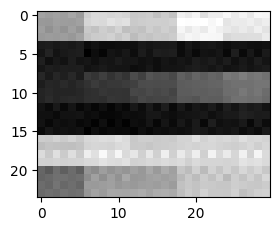

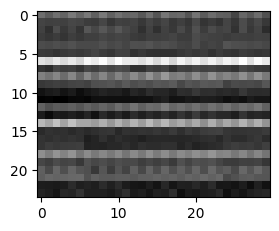

Time cost in one epoch 4.48845100402832 s
[201/2000] loss_d: -0.342, loss_g: 1.901
Time cost in one epoch 4.340174674987793 s
[202/2000] loss_d: -0.414, loss_g: 1.341
Time cost in one epoch 4.313870906829834 s
[203/2000] loss_d: -0.273, loss_g: 2.732
Time cost in one epoch 4.594280242919922 s
[204/2000] loss_d: -0.350, loss_g: 2.427
Time cost in one epoch 4.357180595397949 s
[205/2000] loss_d: -0.279, loss_g: 1.411
Time cost in one epoch 4.372452735900879 s
[206/2000] loss_d: -0.311, loss_g: 1.780
Time cost in one epoch 4.380892515182495 s
[207/2000] loss_d: -0.321, loss_g: 2.025
Time cost in one epoch 4.305988550186157 s
[208/2000] loss_d: -0.422, loss_g: 2.602
Time cost in one epoch 4.4139933586120605 s
[209/2000] loss_d: -0.329, loss_g: 1.980
Time cost in one epoch 4.353132009506226 s
[210/2000] loss_d: -0.251, loss_g: 2.533
Time cost in one epoch 4.346404075622559 s
[211/2000] loss_d: -0.306, loss_g: 2.640
Time cost in one epoch 4.408122777938843 s
[212/2000] loss_d: -0.279, loss_g

<Figure size 640x480 with 0 Axes>

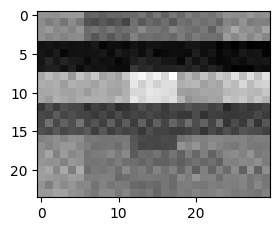

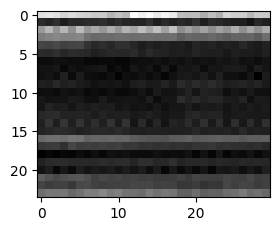

Time cost in one epoch 10.320637702941895 s
[226/2000] loss_d: -0.352, loss_g: -0.103
Time cost in one epoch 9.404937982559204 s
[227/2000] loss_d: -0.250, loss_g: -0.181
Time cost in one epoch 9.449413776397705 s
[228/2000] loss_d: -0.455, loss_g: -0.138
Time cost in one epoch 8.439737558364868 s
[229/2000] loss_d: -0.346, loss_g: -1.000
Time cost in one epoch 4.098562240600586 s
[230/2000] loss_d: -0.347, loss_g: -1.977
Time cost in one epoch 4.128284215927124 s
[231/2000] loss_d: -0.384, loss_g: -1.438
Time cost in one epoch 4.1102635860443115 s
[232/2000] loss_d: -0.333, loss_g: -0.021
Time cost in one epoch 4.193296432495117 s
[233/2000] loss_d: -0.345, loss_g: 0.046
Time cost in one epoch 4.110497236251831 s
[234/2000] loss_d: -0.316, loss_g: -1.278
Time cost in one epoch 4.178662538528442 s
[235/2000] loss_d: -0.252, loss_g: -0.785
Time cost in one epoch 4.136415958404541 s
[236/2000] loss_d: -0.224, loss_g: -2.259
Time cost in one epoch 4.209818363189697 s
[237/2000] loss_d: -0

<Figure size 640x480 with 0 Axes>

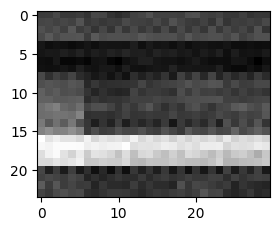

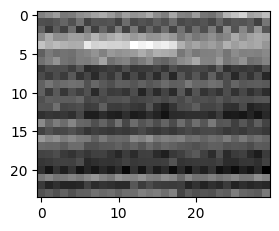

Time cost in one epoch 4.50670599937439 s
[251/2000] loss_d: -0.187, loss_g: -0.167
Time cost in one epoch 4.243990898132324 s
[252/2000] loss_d: -0.309, loss_g: 2.315
Time cost in one epoch 4.292559862136841 s
[253/2000] loss_d: -0.187, loss_g: 0.028
Time cost in one epoch 4.347725868225098 s
[254/2000] loss_d: -0.382, loss_g: 0.917
Time cost in one epoch 4.356403112411499 s
[255/2000] loss_d: -0.275, loss_g: 0.470
Time cost in one epoch 4.420543193817139 s
[256/2000] loss_d: -0.353, loss_g: 1.484
Time cost in one epoch 4.332067489624023 s
[257/2000] loss_d: -0.359, loss_g: 2.255
Time cost in one epoch 4.333942651748657 s
[258/2000] loss_d: -0.406, loss_g: 0.492
Time cost in one epoch 4.475417613983154 s
[259/2000] loss_d: -0.219, loss_g: 1.225
Time cost in one epoch 4.373366832733154 s
[260/2000] loss_d: -0.234, loss_g: 1.048
Time cost in one epoch 4.339543104171753 s
[261/2000] loss_d: -0.304, loss_g: 2.184
Time cost in one epoch 4.385517358779907 s
[262/2000] loss_d: -0.204, loss_g

<Figure size 640x480 with 0 Axes>

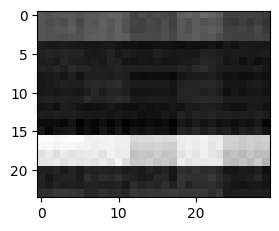

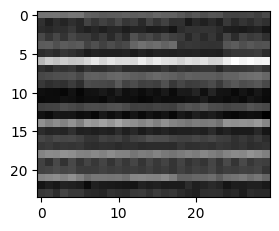

Time cost in one epoch 5.8190758228302 s
[276/2000] loss_d: -0.224, loss_g: 0.009
Time cost in one epoch 9.442752361297607 s
[277/2000] loss_d: -0.244, loss_g: -2.115
Time cost in one epoch 9.420753240585327 s
[278/2000] loss_d: -0.261, loss_g: 1.511
Time cost in one epoch 9.657639265060425 s
[279/2000] loss_d: -0.267, loss_g: -0.911
Time cost in one epoch 9.51047968864441 s
[280/2000] loss_d: -0.261, loss_g: 0.797
Time cost in one epoch 9.424572229385376 s
[281/2000] loss_d: -0.228, loss_g: 0.654
Time cost in one epoch 9.064949750900269 s
[282/2000] loss_d: -0.222, loss_g: -0.841
Time cost in one epoch 4.076760292053223 s
[283/2000] loss_d: -0.235, loss_g: -2.080
Time cost in one epoch 4.096376419067383 s
[284/2000] loss_d: -0.294, loss_g: -0.996
Time cost in one epoch 4.087514400482178 s
[285/2000] loss_d: -0.392, loss_g: 0.300
Time cost in one epoch 4.144345045089722 s
[286/2000] loss_d: -0.183, loss_g: 1.892
Time cost in one epoch 4.141985654830933 s
[287/2000] loss_d: -0.229, loss

<Figure size 640x480 with 0 Axes>

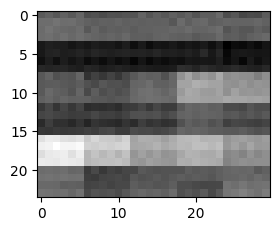

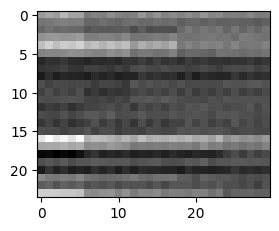

Time cost in one epoch 4.506159782409668 s
[301/2000] loss_d: -0.281, loss_g: 1.467
Time cost in one epoch 4.336794853210449 s
[302/2000] loss_d: -0.230, loss_g: 3.069
Time cost in one epoch 4.257182359695435 s
[303/2000] loss_d: -0.258, loss_g: -1.115
Time cost in one epoch 4.319681167602539 s
[304/2000] loss_d: -0.149, loss_g: -1.678
Time cost in one epoch 4.405154705047607 s
[305/2000] loss_d: -0.294, loss_g: 1.074
Time cost in one epoch 4.397382974624634 s
[306/2000] loss_d: -0.104, loss_g: 2.136
Time cost in one epoch 4.318288803100586 s
[307/2000] loss_d: -0.312, loss_g: -0.186
Time cost in one epoch 4.474517822265625 s
[308/2000] loss_d: -0.161, loss_g: 0.546
Time cost in one epoch 4.328921556472778 s
[309/2000] loss_d: -0.204, loss_g: -2.278
Time cost in one epoch 4.345975399017334 s
[310/2000] loss_d: -0.254, loss_g: 0.455
Time cost in one epoch 4.380447149276733 s
[311/2000] loss_d: -0.306, loss_g: -0.544
Time cost in one epoch 4.3632214069366455 s
[312/2000] loss_d: -0.317, 

<Figure size 640x480 with 0 Axes>

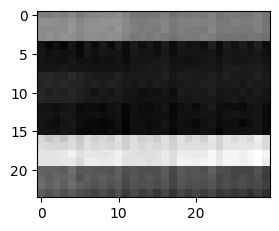

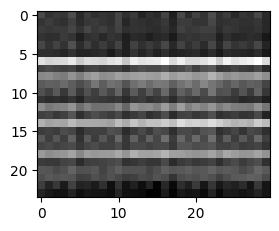

Time cost in one epoch 10.233744144439697 s
[326/2000] loss_d: -0.233, loss_g: -1.342
Time cost in one epoch 9.45262360572815 s
[327/2000] loss_d: -0.233, loss_g: 5.407
Time cost in one epoch 9.713799715042114 s
[328/2000] loss_d: -0.149, loss_g: 1.240
Time cost in one epoch 9.581793308258057 s
[329/2000] loss_d: -0.360, loss_g: -4.210
Time cost in one epoch 8.824643611907959 s
[330/2000] loss_d: -0.192, loss_g: -2.950
Time cost in one epoch 4.085198640823364 s
[331/2000] loss_d: -0.245, loss_g: -1.792
Time cost in one epoch 4.13840389251709 s
[332/2000] loss_d: -0.189, loss_g: 0.023
Time cost in one epoch 4.167859077453613 s
[333/2000] loss_d: -0.293, loss_g: 2.699
Time cost in one epoch 4.211108684539795 s
[334/2000] loss_d: -0.201, loss_g: 1.335
Time cost in one epoch 4.162579298019409 s
[335/2000] loss_d: -0.206, loss_g: 5.398
Time cost in one epoch 4.198870420455933 s
[336/2000] loss_d: -0.202, loss_g: -0.682
Time cost in one epoch 4.169003248214722 s
[337/2000] loss_d: -0.242, lo

<Figure size 640x480 with 0 Axes>

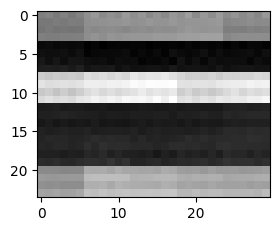

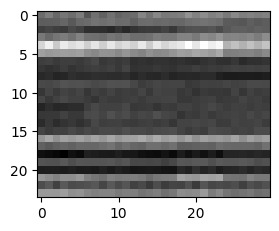

Time cost in one epoch 4.4714860916137695 s
[351/2000] loss_d: -0.317, loss_g: -0.510
Time cost in one epoch 4.279578447341919 s
[352/2000] loss_d: -0.131, loss_g: 2.996
Time cost in one epoch 4.30750036239624 s
[353/2000] loss_d: -0.293, loss_g: 1.589
Time cost in one epoch 4.381649971008301 s
[354/2000] loss_d: -0.164, loss_g: 2.685
Time cost in one epoch 4.358110427856445 s
[355/2000] loss_d: -0.299, loss_g: 2.613
Time cost in one epoch 4.320919752120972 s
[356/2000] loss_d: -0.197, loss_g: 1.759
Time cost in one epoch 4.320352554321289 s
[357/2000] loss_d: -0.242, loss_g: 1.423
Time cost in one epoch 4.345177173614502 s
[358/2000] loss_d: -0.232, loss_g: 5.222
Time cost in one epoch 4.267090320587158 s
[359/2000] loss_d: -0.216, loss_g: -0.172
Time cost in one epoch 4.532872676849365 s
[360/2000] loss_d: -0.171, loss_g: 0.871
Time cost in one epoch 4.33780837059021 s
[361/2000] loss_d: -0.168, loss_g: -0.735
Time cost in one epoch 4.341289281845093 s
[362/2000] loss_d: -0.223, loss

<Figure size 640x480 with 0 Axes>

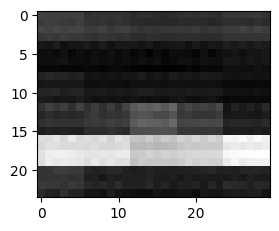

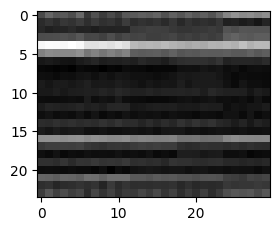

Time cost in one epoch 10.492059707641602 s
[376/2000] loss_d: -0.217, loss_g: 4.937
Time cost in one epoch 10.18459415435791 s
[377/2000] loss_d: -0.186, loss_g: -0.167
Time cost in one epoch 9.761559247970581 s
[378/2000] loss_d: -0.251, loss_g: 2.361
Time cost in one epoch 9.904208183288574 s
[379/2000] loss_d: -0.179, loss_g: -1.036
Time cost in one epoch 8.906402587890625 s
[380/2000] loss_d: -0.210, loss_g: 0.801
Time cost in one epoch 4.107809066772461 s
[381/2000] loss_d: -0.254, loss_g: -2.950
Time cost in one epoch 4.184825658798218 s
[382/2000] loss_d: -0.230, loss_g: -1.796
Time cost in one epoch 4.245920181274414 s
[383/2000] loss_d: -0.139, loss_g: -3.080
Time cost in one epoch 4.439668893814087 s
[384/2000] loss_d: -0.179, loss_g: -2.096
Time cost in one epoch 4.394243478775024 s
[385/2000] loss_d: -0.192, loss_g: -2.339
Time cost in one epoch 4.700321197509766 s
[386/2000] loss_d: -0.253, loss_g: -2.069
Time cost in one epoch 5.155480146408081 s
[387/2000] loss_d: -0.22

<Figure size 640x480 with 0 Axes>

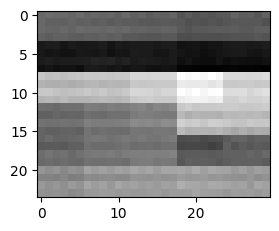

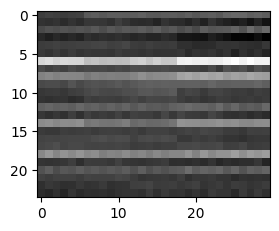

Time cost in one epoch 5.665841102600098 s
[401/2000] loss_d: -0.192, loss_g: -2.790
Time cost in one epoch 5.840694189071655 s
[402/2000] loss_d: -0.211, loss_g: -2.805
Time cost in one epoch 10.399593591690063 s
[403/2000] loss_d: -0.350, loss_g: -6.316
Time cost in one epoch 11.321950435638428 s
[404/2000] loss_d: -0.160, loss_g: -3.429
Time cost in one epoch 10.786774158477783 s
[405/2000] loss_d: -0.272, loss_g: -3.085
Time cost in one epoch 10.838156461715698 s
[406/2000] loss_d: -0.215, loss_g: -0.411
Time cost in one epoch 10.538734197616577 s
[407/2000] loss_d: -0.371, loss_g: -4.514
Time cost in one epoch 10.660300970077515 s
[408/2000] loss_d: -0.169, loss_g: -1.711
Time cost in one epoch 10.619611501693726 s
[409/2000] loss_d: -0.226, loss_g: 0.833
Time cost in one epoch 10.998023986816406 s
[410/2000] loss_d: -0.153, loss_g: -2.751
Time cost in one epoch 10.174952268600464 s
[411/2000] loss_d: -0.174, loss_g: -1.622
Time cost in one epoch 4.668882846832275 s
[412/2000] los

<Figure size 640x480 with 0 Axes>

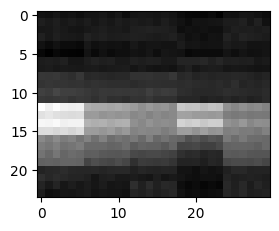

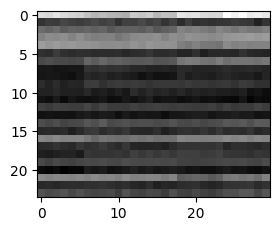

Time cost in one epoch 5.590879678726196 s
[426/2000] loss_d: -0.189, loss_g: -2.281
Time cost in one epoch 5.326661109924316 s
[427/2000] loss_d: -0.265, loss_g: -0.525
Time cost in one epoch 5.166971921920776 s
[428/2000] loss_d: -0.217, loss_g: 5.647
Time cost in one epoch 5.401492118835449 s
[429/2000] loss_d: -0.187, loss_g: -0.568
Time cost in one epoch 5.388790845870972 s
[430/2000] loss_d: -0.218, loss_g: 1.313
Time cost in one epoch 5.492657899856567 s
[431/2000] loss_d: -0.202, loss_g: -1.114
Time cost in one epoch 5.156412363052368 s
[432/2000] loss_d: -0.133, loss_g: -0.140
Time cost in one epoch 5.47105598449707 s
[433/2000] loss_d: -0.198, loss_g: 0.900
Time cost in one epoch 5.65235447883606 s
[434/2000] loss_d: -0.152, loss_g: 1.266
Time cost in one epoch 10.5924232006073 s
[435/2000] loss_d: -0.190, loss_g: -2.579
Time cost in one epoch 10.79427719116211 s
[436/2000] loss_d: -0.188, loss_g: -0.668
Time cost in one epoch 11.288487434387207 s
[437/2000] loss_d: -0.172, l

<Figure size 640x480 with 0 Axes>

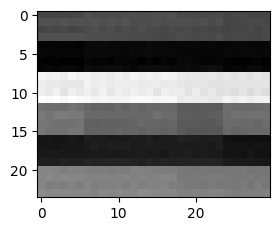

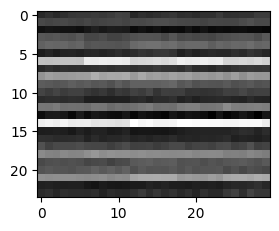

Time cost in one epoch 5.355085849761963 s
[451/2000] loss_d: -0.187, loss_g: 4.248
Time cost in one epoch 5.245062828063965 s
[452/2000] loss_d: -0.187, loss_g: -1.127
Time cost in one epoch 5.335559844970703 s
[453/2000] loss_d: -0.214, loss_g: 1.488
Time cost in one epoch 5.118997573852539 s
[454/2000] loss_d: -0.171, loss_g: 0.407
Time cost in one epoch 5.349846601486206 s
[455/2000] loss_d: -0.228, loss_g: 0.229
Time cost in one epoch 5.511803150177002 s
[456/2000] loss_d: -0.238, loss_g: -0.152
Time cost in one epoch 5.2589311599731445 s
[457/2000] loss_d: -0.157, loss_g: 0.266
Time cost in one epoch 5.403727769851685 s
[458/2000] loss_d: -0.135, loss_g: 0.141
Time cost in one epoch 5.196897745132446 s
[459/2000] loss_d: -0.140, loss_g: -1.701
Time cost in one epoch 5.368997573852539 s
[460/2000] loss_d: -0.189, loss_g: 4.062
Time cost in one epoch 5.227901458740234 s
[461/2000] loss_d: -0.137, loss_g: -2.690
Time cost in one epoch 10.934747219085693 s
[462/2000] loss_d: -0.175, 

<Figure size 640x480 with 0 Axes>

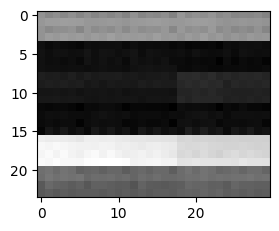

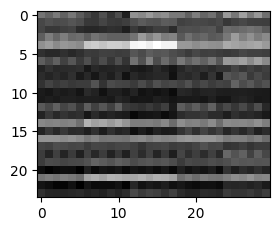

Time cost in one epoch 5.162357568740845 s
[476/2000] loss_d: -0.140, loss_g: 3.812
Time cost in one epoch 4.314793825149536 s
[477/2000] loss_d: -0.230, loss_g: 0.577
Time cost in one epoch 4.282309055328369 s
[478/2000] loss_d: -0.152, loss_g: 1.624
Time cost in one epoch 4.2531514167785645 s
[479/2000] loss_d: -0.236, loss_g: 3.296
Time cost in one epoch 4.3191821575164795 s
[480/2000] loss_d: -0.168, loss_g: 3.688
Time cost in one epoch 4.3506176471710205 s
[481/2000] loss_d: -0.196, loss_g: 0.268
Time cost in one epoch 4.343097448348999 s
[482/2000] loss_d: -0.145, loss_g: 3.444
Time cost in one epoch 4.302330732345581 s
[483/2000] loss_d: -0.184, loss_g: 1.200
Time cost in one epoch 4.2723963260650635 s
[484/2000] loss_d: -0.156, loss_g: 5.019
Time cost in one epoch 4.27501368522644 s
[485/2000] loss_d: -0.208, loss_g: 2.519
Time cost in one epoch 4.46371054649353 s
[486/2000] loss_d: -0.175, loss_g: 0.279
Time cost in one epoch 4.375950336456299 s
[487/2000] loss_d: -0.114, loss

<Figure size 640x480 with 0 Axes>

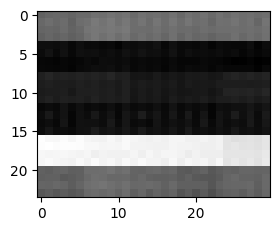

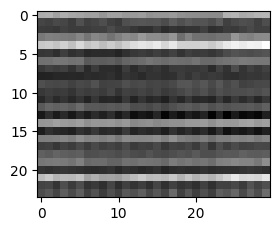

Time cost in one epoch 4.680823802947998 s
[501/2000] loss_d: -0.176, loss_g: 6.650
Time cost in one epoch 4.555333375930786 s
[502/2000] loss_d: -0.256, loss_g: 2.173
Time cost in one epoch 5.508155822753906 s
[503/2000] loss_d: -0.191, loss_g: -0.313
Time cost in one epoch 10.427481651306152 s
[504/2000] loss_d: -0.192, loss_g: 4.990
Time cost in one epoch 10.24858021736145 s
[505/2000] loss_d: -0.128, loss_g: 2.484
Time cost in one epoch 10.258554697036743 s
[506/2000] loss_d: -0.210, loss_g: 0.462
Time cost in one epoch 10.244588136672974 s
[507/2000] loss_d: -0.108, loss_g: 3.316
Time cost in one epoch 10.491917133331299 s
[508/2000] loss_d: -0.111, loss_g: 2.879
Time cost in one epoch 10.459018230438232 s
[509/2000] loss_d: -0.136, loss_g: 3.053
Time cost in one epoch 4.210933208465576 s
[510/2000] loss_d: -0.185, loss_g: 1.271
Time cost in one epoch 4.244451999664307 s
[511/2000] loss_d: -0.178, loss_g: 3.494
Time cost in one epoch 4.229619979858398 s
[512/2000] loss_d: -0.105, 

RuntimeError: DataLoader worker (pid(s) 8988) exited unexpectedly

In [11]:
model.train_model(
    x_train = data_alt_3_4,     
    y_train = label_alt_onehot,     
    dataloder_num_workers = 1,
    train_epoch = 2000,  #17000
    step_valid = 25, #50
    step_save_data = 1000, #1000
    iteration_generator = (2000//batch_size) + 1, # 2000 samples 
    n_critic = 5, #5
    )

In [ ]:
model.show_train_hist()

In [ ]:
torch.cuda.empty_cache()

# Show generated data

In [ ]:
# gen_trained = torch.load(saver_path + 'gen.pkl')

# ############        num_alternative = 3      #######################
# z_fake = torch.randn(batch_size, dim_z, 1, 1).to(device)
# z_label = np.zeros([batch_size, 1]) + 0
# z_label = one_hot(z_label, num_class).reshape([batch_size, num_class, 1, 1])
# z_label = torch.Tensor(z_label).to(device)    

# gen_alt3 = gen_trained(z_fake, z_label)
# ############        num_alternative = 4      #######################
# z_fake = torch.randn(batch_size, dim_z, 1, 1).to(device)
# z_label = np.zeros([batch_size, 1]) + 1
# z_label = one_hot(z_label, num_class).reshape([batch_size, num_class, 1, 1])
# z_label = torch.Tensor(z_label).to(device)    

# gen_alt4 = gen_trained(z_fake, z_label)

# plt.figure(epoch)
# fig, ax = plt.subplots(figsize=(3, 3))
# ax.cla()
# ax.imshow(gen_alt3.data.cpu().numpy()[0], cmap='gray')

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.cla()
# ax.imshow(gen_alt4.data.cpu().numpy()[0], cmap='gray')            
# plt.show()